# Neural Networks and Optimization

As we saw in class, a powerful tool in supervised machine learning is Empirical Risk Minimization. It usually involves solving a problem of the form

$$
\hat{f} \in \text{argmin}_{f \in F} \frac{1}{n} \sum_{i=1}^n l(f(x_i), y_i) + \lambda \Omega (f)
$$
where

- $F$ is the class of predictors of interest
- $(x_1, y_1), \dots, (x_n, y_n)$ are the training examples
- $l$ is the loss function
- $\Omega (\cdot)$ is a regularization function

Neural networks usually refer to a specific class of functions $F$. In this TP, we will investigate a subclass of Neural networks : The fully-connected feed-forward neural networks.

This TP will explore the training of such neural networks with so-called first-order optimization methods.


To get started, run the following code to import the libraries you will need.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets



%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
import sklearn
import sklearn.datasets

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)

    return s

def load_params_and_grads(seed=1):
    np.random.seed(seed)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)

    return W1, b1, W2, b2, dW1, db1, dW2, db2


def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])

    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1].
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
        assert(parameters['W' + str(l)].shape == layer_dims[l], 1)

    return parameters


def compute_cost(a3, Y):

    """
    Implement the cost function

    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3

    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]

    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.sum(logprobs)

    return cost

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.

    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()

    Returns:
    loss -- the loss function (vanilla logistic loss)
    """

    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)

    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)

    return a3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.

    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()

    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache

    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)

    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)

    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)

    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}

    return gradients

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)

    # Forward propagation
    a3, caches = forward_propagation(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))

    return p

def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);

    return train_X, train_Y, test_X, test_Y

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (m, K)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3 > 0.5)
    return predictions

def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))

    return train_X, train_Y

def update_parameters_with_gd_test_case():
    np.random.seed(1)
    learning_rate = 0.01
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return parameters, grads, learning_rate

"""
def update_parameters_with_sgd_checker(function, inputs, outputs):
    if function(inputs) == outputs:
        print("Correct")
    else:
        print("Incorrect")
"""

def random_mini_batches_test_case():
    np.random.seed(1)
    mini_batch_size = 64
    X = np.random.randn(12288, 148)
    Y = np.random.randn(1, 148) < 0.5
    return X, Y, mini_batch_size

def initialize_velocity_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

def update_parameters_with_momentum_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    v = {'dW1': np.array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
        [ 0.]]), 'db2': np.array([[ 0.],
        [ 0.],
        [ 0.]])}
    return parameters, grads, v

def initialize_adam_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

def update_parameters_with_adam_test_case():
    np.random.seed(1)
    v, s = ({'dW1': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
         [ 0.]]), 'db2': np.array([[ 0.],
         [ 0.],
         [ 0.]])}, {'dW1': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
         [ 0.]]), 'db2': np.array([[ 0.],
         [ 0.],
         [ 0.]])})
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return parameters, grads, v, s

<>:72: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:73: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:72: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:73: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-2-13c8cc7c0d17>:72: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
<ipython-input-2-13c8cc7c0d17>:73: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


We will train our model on the following  "moons" dataset to test the different optimization methods. The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.
The aim is to separate the red from the blue dots. We focus for now just on the training phase (we do not tune the hyperparameters of the model and do not use a testing set to assess the performance).

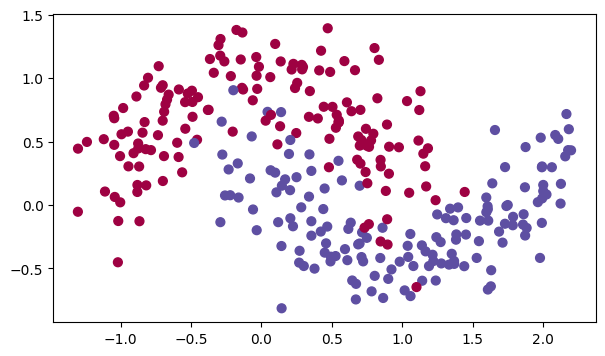

In [ ]:
train_X, train_Y = load_dataset()

**Question :** By looking at the functions compute_cost(.) and predict(.) above, detail the class of functions of interest $F$, the loss function $l$ and how to make predictions from $\hat{f}$. Identify the trainable parametters.

## 1 - Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent.

We consider as a model a neural network with $L$ layers, whose parameters are the weights "W" and the biases "b".

Implement the gradient descent update rule. This can be done layer-wise. The  gradient descent rule is then, for $l = 1, ..., L$:
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

where $\alpha$ is the learning rate.

All parameters should be stored in the `parameters` dictionary. The sintax is the following one:
`
parameters["W" + str(l)]
`
which represents $W^{[l]}$.

Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

**Question :** Complete the following code

In [ ]:
#  update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)

        ### END CODE HERE ###

    return parameters

Try your update on the following test case.
The expected output is:
\begin{align}
W1 &= [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]\\
b1 &= [[ 1.74604067]
 [-0.75184921]]\\
W2 &= [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]\\
b2 &= [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]
 \end{align}

In [ ]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


**Question :** Ignoring the possible points where the function to optimize is not differentiable, explain how the chain rule can be leveraged to compute the gradients. You will also give the formulas that are useful for the implementation.

## 2 - Stochastic variants of Gradient Descent



Stochastic variants of Gradient Descent compute gradients on just some training examples at a time, rather than on the whole training set. These are often called mini-batch gradient descent. The so-called Stochastic Gradient  Descent (SGD) method is a mini-batch method  where each mini-batch has just 1 example.

The update rule that you have just implemented does not change, the difference is that it is not used on all the samples.  

When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly.

**Note** also that implementing SGD requires 3 for-loops in total:
1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)


The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent.

**(Batch) Gradient Descent**:
``` python
# Data
X = data_input
Y = labels
# Network parameters (W,b)
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    # Forward propagation (use model to make prediction)
    a, caches = forward_propagation(X, parameters)
    # Compute cost (compute the loss function)
    cost = compute_cost(a, Y)
    # Backward propagation, used to compute gradients when using neural networks. It requires the informations computed during the forward pass (stored in 'caches') to be done in an efficient way. Cf. opt_utils.py
    grads = backward_propagation(a, caches, parameters)
    # Update parameters of the network
    parameters = update_parameters(parameters, grads)
```
**Stochastic Gradient Descent**:
``` python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
  # m total number of training samples
    for j in range(0, m):
        # Forward propagation
        a, caches = forward_propagation(X[:,j], parameters)
        # Compute cost
        cost = compute_cost(a, Y[:,j])
        # Backward propagation
        grads = backward_propagation(a, caches, parameters)
        # Update parameters.
        parameters = update_parameters(parameters, grads)

```

# Mini-Batch Gradient descent

In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.


Let's learn how to build mini-batches from the training set (X, Y).

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y). Each column of X and Y represents a training example. Note that the random shuffling must be done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches.



- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size`. Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this.


**Exercise**: Implement `random_mini_batches`. We coded the shuffling part for you.

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\lfloor \frac{m}{mini\_batch\_size}\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be ($m-mini_\_batch_\_size \times \lfloor \frac{m}{mini\_batch\_size}\rfloor$).

**Question :** Complete the following code

In [ ]:
#  random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """


    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)

        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)


        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

Test your mini-batch code on the following test case. The expected output is:


1. shape of the 1st mini_batch_X: (12288, 64)
2. shape of the 2nd mini_batch_X: (12288, 64)
3. shape of the 3rd mini_batch_X: (12288, 20)
4. shape of the 1st mini_batch_Y: (1, 64)
5. shape of the 2nd mini_batch_Y: (1, 64)
6. shape of the 3rd mini_batch_Y: (1, 20)
7. mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]

In [ ]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches= random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape))
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


**What you should remember**:
- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you use to perform one update step.
- You have to tune a learning rate hyperparameter $\alpha$.
- With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

## 3 - Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.




**Exercise**: Initialize the velocity. The velocity, $v$, is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the `grads` dictionary, that is:
for $l =1,...,L$:
```python
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```
**Note** that the iterator l starts at 0 in the for loop while the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript). This is why we are shifting l to l+1 in the `for` loop.

In [ ]:
#  initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl

    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}

    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)

        ### END CODE HERE ###

    return v

Test your code, expected output:
\begin{align}
v["dW1"] &= [[0. 0. 0.]
 [0. 0. 0.]]\\
v["db1"] &= [[0.]
 [0.]]\\
v["dW2"] &= [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]\\
v["db2"] &= [[0.]
 [0.]
 [0.]]
 \end{align}


In [ ]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


**Exercise**:  Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$:

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}}
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.

In [ ]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Momentum update for each parameter
    for l in range(L):

        ### START CODE HERE ### (approx. 4 lines)


        ### END CODE HERE ###

    return parameters, v

**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum.

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much.
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default.
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$.


**What you should remember**:
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

## Training time!
You now have three working optimization algorithms (gradient, mini-batch gradient descent, Momentum). Let's train a model with each of these optimizers and observe the difference.

We will use a 3-layer neural network. You will train it with:
- Mini-batch **Gradient Descent**: it will call your function:
    - `update_parameters_with_gd()`
- Mini-batch **Momentum**: it will call your functions:
    - `initialize_velocity()` and `update_parameters_with_momentum()`


Here the function to train the model (the model is defined in opt_utils.py) when you use mini batches:

In [ ]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.

    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    # Optimization loop
    for i in range(num_epochs):

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)

        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Adapt this function to do the training with the standard gradient descent (no minibatches):

In [ ]:
def modelg(X, Y, layers_dims, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.

    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)



    # Optimization loop
    for i in range(num_epochs):



        a3, caches = forward_propagation(X, parameters)
        cost = compute_cost(a3, Y)
        # Backward propagation
        grads = backward_propagation(X, Y, caches)

        parameters = update_parameters_with_gd(parameters, grads, learning_rate)

        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

You will now run this 3 layer neural network with each of the 3 optimization methods.

### 5.1 - Standard Gradient descent

Run the following code to see how the model performs with batch gradient descent. Can you improve the performance of the method ?

(Change the learning rate)

Cost after epoch 0: 0.702414
Cost after epoch 1000: 0.635318
Cost after epoch 2000: 0.573350
Cost after epoch 3000: 0.532292
Cost after epoch 4000: 0.496232
Cost after epoch 5000: 0.432805
Cost after epoch 6000: 0.359757
Cost after epoch 7000: 0.338092
Cost after epoch 8000: 0.326472
Cost after epoch 9000: 0.318030
Cost after epoch 10000: 0.312054
Cost after epoch 11000: 0.307841
Cost after epoch 12000: 0.304526
Cost after epoch 13000: 0.301455
Cost after epoch 14000: 0.298385
Cost after epoch 15000: 0.294580
Cost after epoch 16000: 0.289168
Cost after epoch 17000: 0.281786
Cost after epoch 18000: 0.271501
Cost after epoch 19000: 0.260724
Cost after epoch 20000: 0.248527
Cost after epoch 21000: 0.229980
Cost after epoch 22000: 0.213060
Cost after epoch 23000: 0.194023
Cost after epoch 24000: 0.180847
Cost after epoch 25000: 0.170335
Cost after epoch 26000: 0.162378
Cost after epoch 27000: 0.156653
Cost after epoch 28000: 0.152997
Cost after epoch 29000: 0.150751
Cost after epoch 30000:

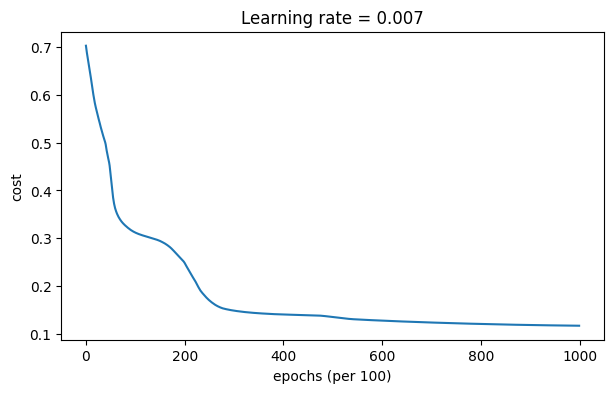

Accuracy: 0.9433333333333334


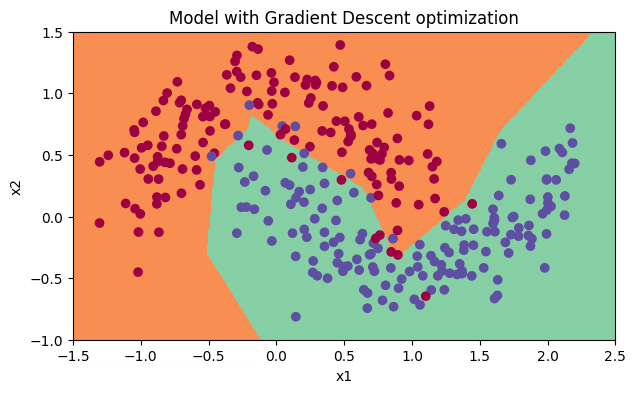

In [ ]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = modelg(train_X, train_Y, layers_dims, learning_rate = 0.007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 100000, print_cost = True)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.1 - Mini batch Gradient descent

Run the following code to see how the model performs with batch gradient descent.

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518
Cost after epoch 10000: 0.384953
Cost after epoch 11000: 0.396139
Cost after epoch 12000: 0.392297
Cost after epoch 13000: 0.307115
Cost after epoch 14000: 0.250737
Cost after epoch 15000: 0.361416
Cost after epoch 16000: 0.307576
Cost after epoch 17000: 0.338970
Cost after epoch 18000: 0.257706
Cost after epoch 19000: 0.289061
Cost after epoch 20000: 0.237487
Cost after epoch 21000: 0.245424
Cost after epoch 22000: 0.423519
Cost after epoch 23000: 0.229969
Cost after epoch 24000: 0.281042
Cost after epoch 25000: 0.429658
Cost after epoch 26000: 0.319283
Cost after epoch 27000: 0.252164
Cost after epoch 28000: 0.335096
Cost after epoch 29000: 0.313833
Cost after epoch 30000:

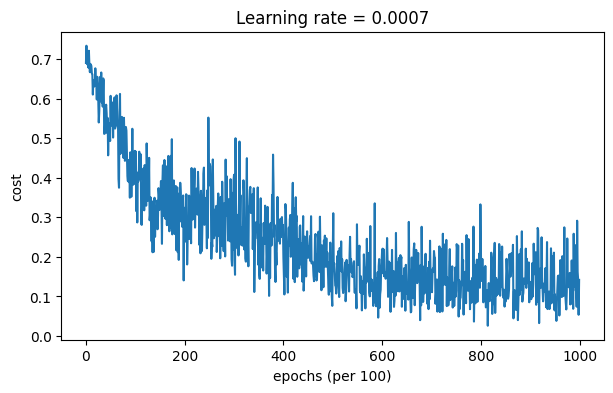

Accuracy: 0.9333333333333333


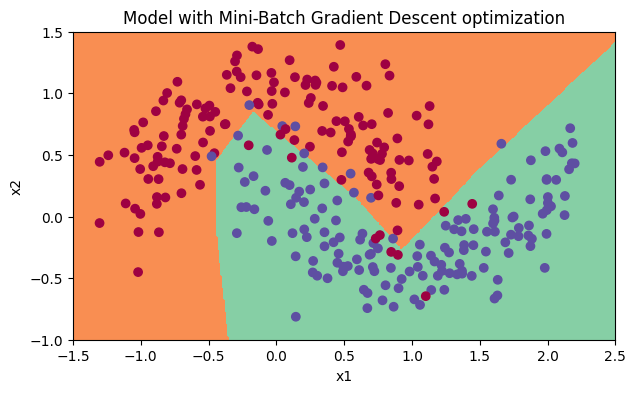

In [ ]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 100000, print_cost = True)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Mini-Batch Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.2 - Mini-batch gradient descent with momentum

Run the following code to see how the model does with momentum. Because this example is relatively simple, the gains from using momemtum are small; but for more complex problems you might see bigger gains.

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740
Cost after epoch 10000: 0.385268
Cost after epoch 11000: 0.396533
Cost after epoch 12000: 0.392403
Cost after epoch 13000: 0.307228
Cost after epoch 14000: 0.250762
Cost after epoch 15000: 0.361475
Cost after epoch 16000: 0.307638
Cost after epoch 17000: 0.339029
Cost after epoch 18000: 0.257704
Cost after epoch 19000: 0.289101
Cost after epoch 20000: 0.237514
Cost after epoch 21000: 0.245427
Cost after epoch 22000: 0.423523
Cost after epoch 23000: 0.229977
Cost after epoch 24000: 0.281032
Cost after epoch 25000: 0.429655
Cost after epoch 26000: 0.319238
Cost after epoch 27000: 0.252149
Cost after epoch 28000: 0.335089
Cost after epoch 29000: 0.313807
Cost after epoch 30000:

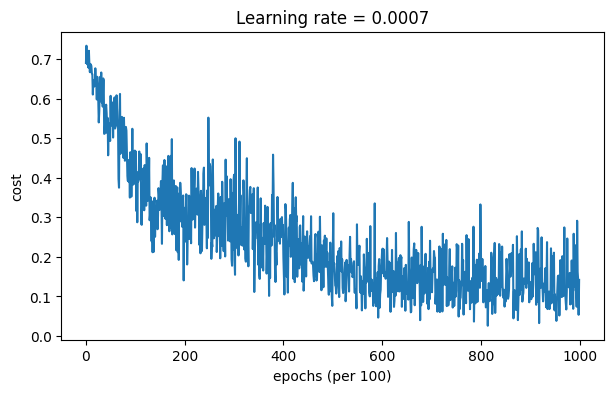

Accuracy: 0.9333333333333333


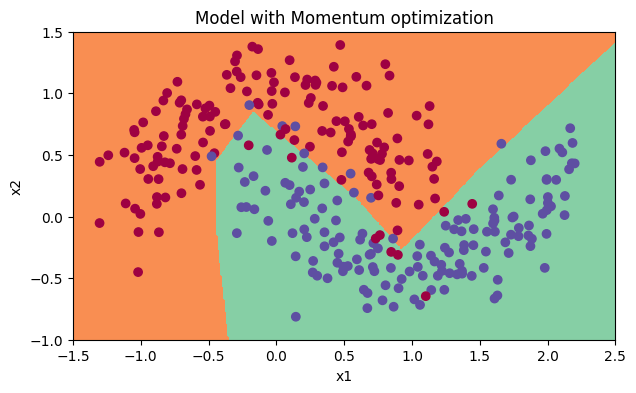

In [ ]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 100000, print_cost = True)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)


  

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

If you run the model for more epochs on this simple dataset, all three methods will lead to very good results.





## 4 - To go further: Adam method

Adam is one of the most effective optimization algorithms for training neural networks.

**Reference**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction).
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction).
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$:

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- J is the cost function
- t counts the number of steps taken of Adam
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages.
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  


If you run the model for more epochs on this simple dataset, you will see that Adam clearly outperforms mini-batch gradient descent and Momentum and converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum)
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**Exercise**: Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l = 1, ..., L$:
```python
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
s["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
s["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])

```

In [ ]:
# initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.

    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl

    Returns:
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)

    ### END CODE HERE ###

    return v, s

In [ ]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))


v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


**Exercise**:  Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$:

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

In [ ]:
# update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates
    beta2 -- Exponential decay hyperparameter for the second moment estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary

    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)

        ### END CODE HERE ###

    return parameters, v, s

### 5.3 - Mini-batch with Adam mode

Run the following code to see how the model does with Adam.

Cost after epoch 0: 0.687550
Cost after epoch 1000: 0.173593
Cost after epoch 2000: 0.150145
Cost after epoch 3000: 0.072939
Cost after epoch 4000: 0.125896
Cost after epoch 5000: 0.104185
Cost after epoch 6000: 0.116069
Cost after epoch 7000: 0.031774
Cost after epoch 8000: 0.112908
Cost after epoch 9000: 0.197732


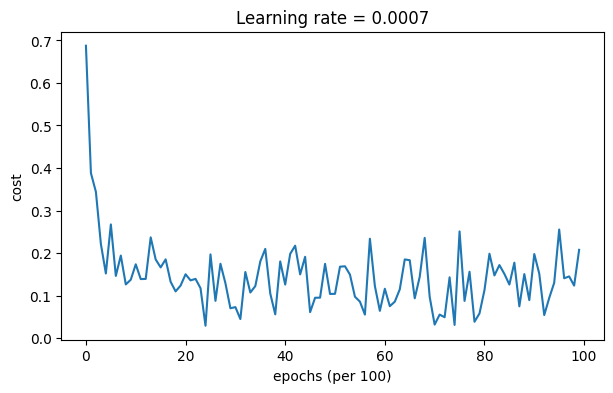

Accuracy: 0.94


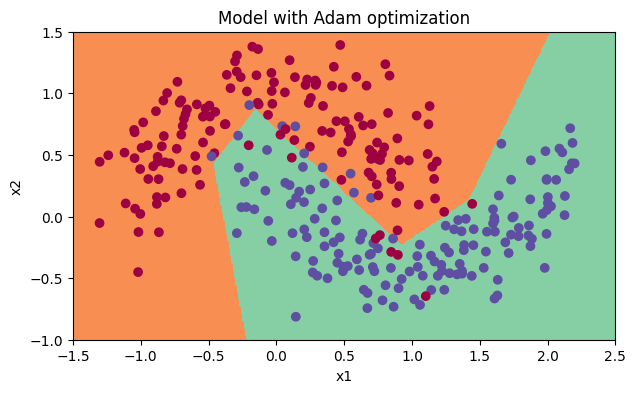

In [ ]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)